In [22]:
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans,KMeansModel


sqlContext = SQLContext(sc)
df = sqlContext.read.csv("D:\\bigdata\\spark\\testdata\\2032Lines.csv", header=True) # requires spark 2.0
#df.select('Line').show()
df.show()
df = df.withColumn('Price',df['Price'].cast('float'))
df = df.withColumn('Price Quantity',df['Price Quantity'].cast('float'))
df = df.withColumn('Delivery Time in Days',df['Delivery Time in Days'].cast('float'))
df = df.na.drop()
df.show()
hierarchyidx = StringIndexer().setInputCol("Hierarchy").setOutputCol("hierarchy_idx")
hierarchyenc=OneHotEncoder().setInputCol("hierarchy_idx").setOutputCol("hierarchy_idx_enc")
unitofmeasureidx = StringIndexer(inputCol="Unit of Measure", outputCol="unitofmeasure_idx")
short_descidx = StringIndexer(inputCol="Short Description", outputCol="short_desc_idx")
Currencyidx = StringIndexer(inputCol="Currency", outputCol="currency_idx")
currency_idxEncoder = OneHotEncoder(inputCol="currency_idx", outputCol="currency_idx_vec")

#kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
assembler = VectorAssembler(inputCols=["Price","Price Quantity","Delivery Time in Days","hierarchy_idx_enc","unitofmeasure_idx","short_desc_idx","currency_idx_vec"],outputCol="features")
#pipeline = Pipeline(stages=[hierarchyidx,hierarchyenc,unitofmeasureidx,short_descidx,Currencyidx,currency_idxEncoder, assembler, kmeans])                      
#model = pipeline.fit(df)
#predictions = model.transform(df)
#print(model.__dict__)
#print(model.stages[-1].computeCost(predictions))
# Predictions



# Select example rows to display.
#predictions.columns 


cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    pipeline = Pipeline(stages=[hierarchyidx,hierarchyenc,unitofmeasureidx,short_descidx,Currencyidx,currency_idxEncoder, assembler, kmeans])                      
    model = pipeline.fit(df)
    predictions = model.transform(df)
    cost[k] = model.stages[-1].computeCost(predictions)
 
   
    




+----+--------------------+--------------------+---------------+-----+--------+---------------------+--------------+
|Line|   Short Description|           Hierarchy|Unit of Measure|Price|Currency|Delivery Time in Days|Price Quantity|
+----+--------------------+--------------------+---------------+-----+--------+---------------------+--------------+
|   1|Materials Enginee...|Personnel Monthly...|         Months|  475|     USD|                    1|             1|
|   2|Materials Analyst...|Personnel Monthly...|         Months|  200|     USD|                    1|             1|
|   3|Buyer - Non-National|Personnel Monthly...|         Months|  875|     USD|                    1|             1|
|   4|Purchasing Analys...|Personnel Monthly...|         Months|  875|     USD|                    1|             1|
|   5|Monthly Service C...|      Service Charge|         Months|  513|     USD|                    1|             1|
|   6|Materials Enginee...|Personnel Monthly...|         Months|

Text(0,0.5,'cost')

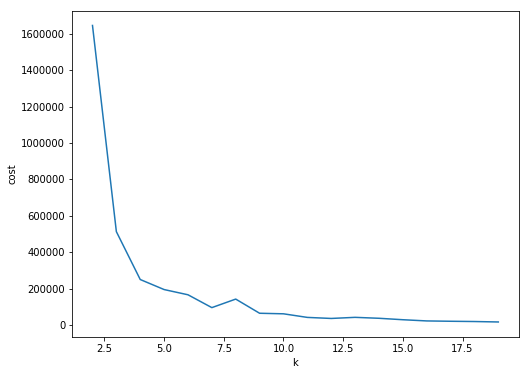

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [24]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
pipeline = Pipeline(stages=[hierarchyidx,hierarchyenc,unitofmeasureidx,short_descidx,Currencyidx,currency_idxEncoder, assembler, kmeans])                      
model = pipeline.fit(df)
predictions = model.transform(df)
cost = model.stages[-1].computeCost(predictions)
print(cost)
centers = model.stages[-1].clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)


62161.21984126976
Cluster Centers: 
[666.   1.   1.   1.   0.   0.  32.   0.]
[352.66666667   1.           1.           0.55555556   0.44444444
   0.          44.16666667   0.83333333]
[171.42857143   1.           1.           1.           0.
   0.          19.28571429   0.71428571]
[877.16666667   1.           1.           1.           0.
   0.           9.33333333   1.        ]
[4.711e+02 1.000e+00 1.000e+00 9.000e-01 1.000e-01 0.000e+00 2.040e+01
 8.000e-01]
[29.57142857  1.          1.          1.          0.          0.
 23.71428571  0.71428571]
[563.125   1.      1.      1.      0.      0.     37.25    0.75 ]
[5.01857143e+02 1.00000000e+00 1.00000000e+00 7.14285714e-01
 1.42857143e-01 0.00000000e+00 5.32857143e+01 1.00000000e+00]
[7.98875e+02 1.00000e+00 1.00000e+00 6.25000e-01 3.75000e-01 0.00000e+00
 3.83750e+01 8.75000e-01]
[7.25e+02 1.00e+00 1.00e+00 7.50e-01 2.50e-01 0.00e+00 4.90e+01 1.00e+00]


In [27]:
transformed = predictions.select('Line', 'prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()
df_pred = df_pred.join(df, 'Line')
df_pred.show()

+----+----------+
|Line|prediction|
+----+----------+
|   1|         4|
|   2|         2|
|   3|         3|
|   4|         3|
|   5|         7|
|   6|         4|
|   7|         8|
|   8|         2|
|   9|         3|
|  10|         1|
|  11|         3|
|  12|         1|
|  13|         3|
|  14|         1|
|  15|         5|
|  16|         5|
|  17|         8|
|  18|         1|
|  19|         1|
|  20|         6|
+----+----------+
only showing top 20 rows

+----+----------+--------------------+--------------------+---------------+-----+--------+---------------------+--------------+
|Line|prediction|   Short Description|           Hierarchy|Unit of Measure|Price|Currency|Delivery Time in Days|Price Quantity|
+----+----------+--------------------+--------------------+---------------+-----+--------+---------------------+--------------+
|   1|         4|Materials Enginee...|Personnel Monthly...|         Months|475.0|     USD|                  1.0|           1.0|
|   2|         2|Materials Ana

d:\users\245-0117\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


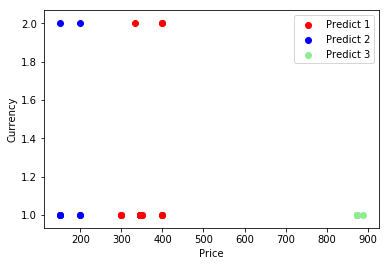

In [48]:
pddf_pred = df_pred.toPandas().set_index('Line')
pddf_pred.head()

y = pddf_pred['prediction']
pddf_pred['Currency_N'] = pddf_pred['Currency'].map({'USD': 1.0, 'SAR': 2.0})
X = pddf_pred.ix[:, 'Short Description':]


plt.scatter(X[y==1]['Price'], X[y==1]['Currency_N'], label='Predict 1', c='red')
plt.scatter(X[y==2]['Price'], X[y==2]['Currency_N'], label='Predict 2', c='blue')
plt.scatter(X[y==3]['Price'], X[y==3]['Currency_N'], label='Predict 3', c='lightgreen')


# Prettify the graph
plt.legend()
plt.xlabel('Price')
plt.ylabel('Currency')

# display
plt.show()

